
Вариант 2. (сложный)
- реализовать нейронную сеть или стек из сверток (Concatenate) на сifar10.
- оценить рост точности при увеличении ширины сети (больше ядер), больше нитей.
- оценить рост точности при увеличении глубины сети (больше слоев)


In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 5.3 MB 4.9 MB/s 
     |████████████████████████████████| 7.6 MB 44.1 MB/s 
     |████████████████████████████████| 163 kB 44.1 MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.datasets.cifar10 import load_data
from albumentations import (
    Compose, HueSaturationValue, HorizontalFlip,
    Rotate, OneOf, ToGray, RandomBrightnessContrast,
)
from functools import partial

In [ ]:
batch_size = 32
num_classes = 10
epochs = 20

(x_train, y_train), (x_test, y_test) = load_data()

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype(np.float32) / 255.
x_test = x_test.astype(np.float32) / 255.

In [ ]:
classes = ['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

In [ ]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [ ]:
transforms = Compose([OneOf([
                            Rotate(limit=40),
                            # ToGray(p=0.5),
                            RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9),
                            HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
                            HorizontalFlip(p=1.),], p=1.0),
                            ])

def aug_fn(image):  # не нормировать при загрузке датасета!
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    return aug_img

def process_image(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
    return aug_img, label

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
# слишком агрессивная аугментация
# train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(partial(process_image), num_parallel_calls=AUTOTUNE).cache().shuffle(1000).batch(batch_size).prefetch(AUTOTUNE)
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).cache().shuffle(1000).batch(batch_size).prefetch(AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).cache().batch(batch_size).prefetch(AUTOTUNE)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
            ]

In [ ]:
history = model.fit(train_ds, epochs=100, validation_data=valid_ds, callbacks=callbacks, verbose=1)

Epoch 1/100
1563/1563 [==============================] - 23s 9ms/step - loss: 1.7065 - accuracy: 0.4064 - val_loss: 1.2605 - val_accuracy: 0.5360 - lr: 0.0010
Epoch 2/100
1563/1563 [==============================] - 13s 8ms/step - loss: 1.1586 - accuracy: 0.5864 - val_loss: 0.9732 - val_accuracy: 0.6534 - lr: 0.0010
Epoch 3/100
1563/1563 [==============================] - 13s 8ms/step - loss: 0.9878 - accuracy: 0.6548 - val_loss: 0.8154 - val_accuracy: 0.7117 - lr: 0.0010
Epoch 4/100
1563/1563 [==============================] - 12s 8ms/step - loss: 0.8791 - accuracy: 0.6930 - val_loss: 0.8859 - val_accuracy: 0.6974 - lr: 0.0010
Epoch 5/100
1563/1563 [==============================] - 16s 11ms/step - loss: 0.8047 - accuracy: 0.7213 - val_loss: 0.6815 - val_accuracy: 0.7669 - lr: 0.0010
Epoch 6/100
1563/1563 [==============================] - 14s 9ms/step - loss: 0.7455 - accuracy: 0.7435 - val_loss: 0.6384 - val_accuracy: 0.7793 - lr: 0.0010
Epoch 7/100
1563/1563 [======================

In [ ]:
model.evaluate(valid_ds)

313/313 [==============================] - 1s 4ms/step - loss: 0.3841 - accuracy: 0.8743


[0.3840728998184204, 0.8743000030517578]

В общем случае чем больше слоев и количество ядер, тем она больше улавлявает сложные зависимости в данных. Однако их большое количество может привести к низкому качеству. Для каждого набора данных необходимо подбирать данные параметры индивидуально. Хорошей практикой должен быть путь от простого к сложному. Если нет четкой начальной интуиции - строим простую модель и постепенно ее усложняем, добавляя слои, фильтры, трюки. Если данных много, то можно для экспериментов взять их репрезентативную подвыборку.

In [ ]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, hidden):
        super(Attention, self).__init__()
        self.k = tf.keras.layers.Dense(hidden)
        self.q = tf.keras.layers.Dense(hidden)
        self.v = tf.keras.layers.Dense(hidden)
        self.d = tf.math.sqrt(float(hidden))

    def call(self, x):
        out_k = self.k(x)
        out_q = self.q(x)
        out_v = self.v(x)
        dot_qk = tf.matmul(out_q, out_k, transpose_b=True)
        weighted_qk = tf.nn.softmax(dot_qk / self.d, axis=-1)
        return tf.matmul(weighted_qk, out_v)

**Crazy Mix**

Берем начальные свертки и после нормализации подаем в ансамбль экстракторов: свертка-пулинг, свертка-свертка, свертка в стиле resnet. Объединяем, выравниваем, подсвеичваем наимболее важные фичи механизмом внимания, передаем на выход в полносвязный слой. Получается мусорная модель (первый блок не нужен, подаем сразу на экстракторы, наверное их количесво лучше увеличить). Для данной задачи лучше использовать что-то более классическое либо иметь более глубокое понимание нужной архитектуры.

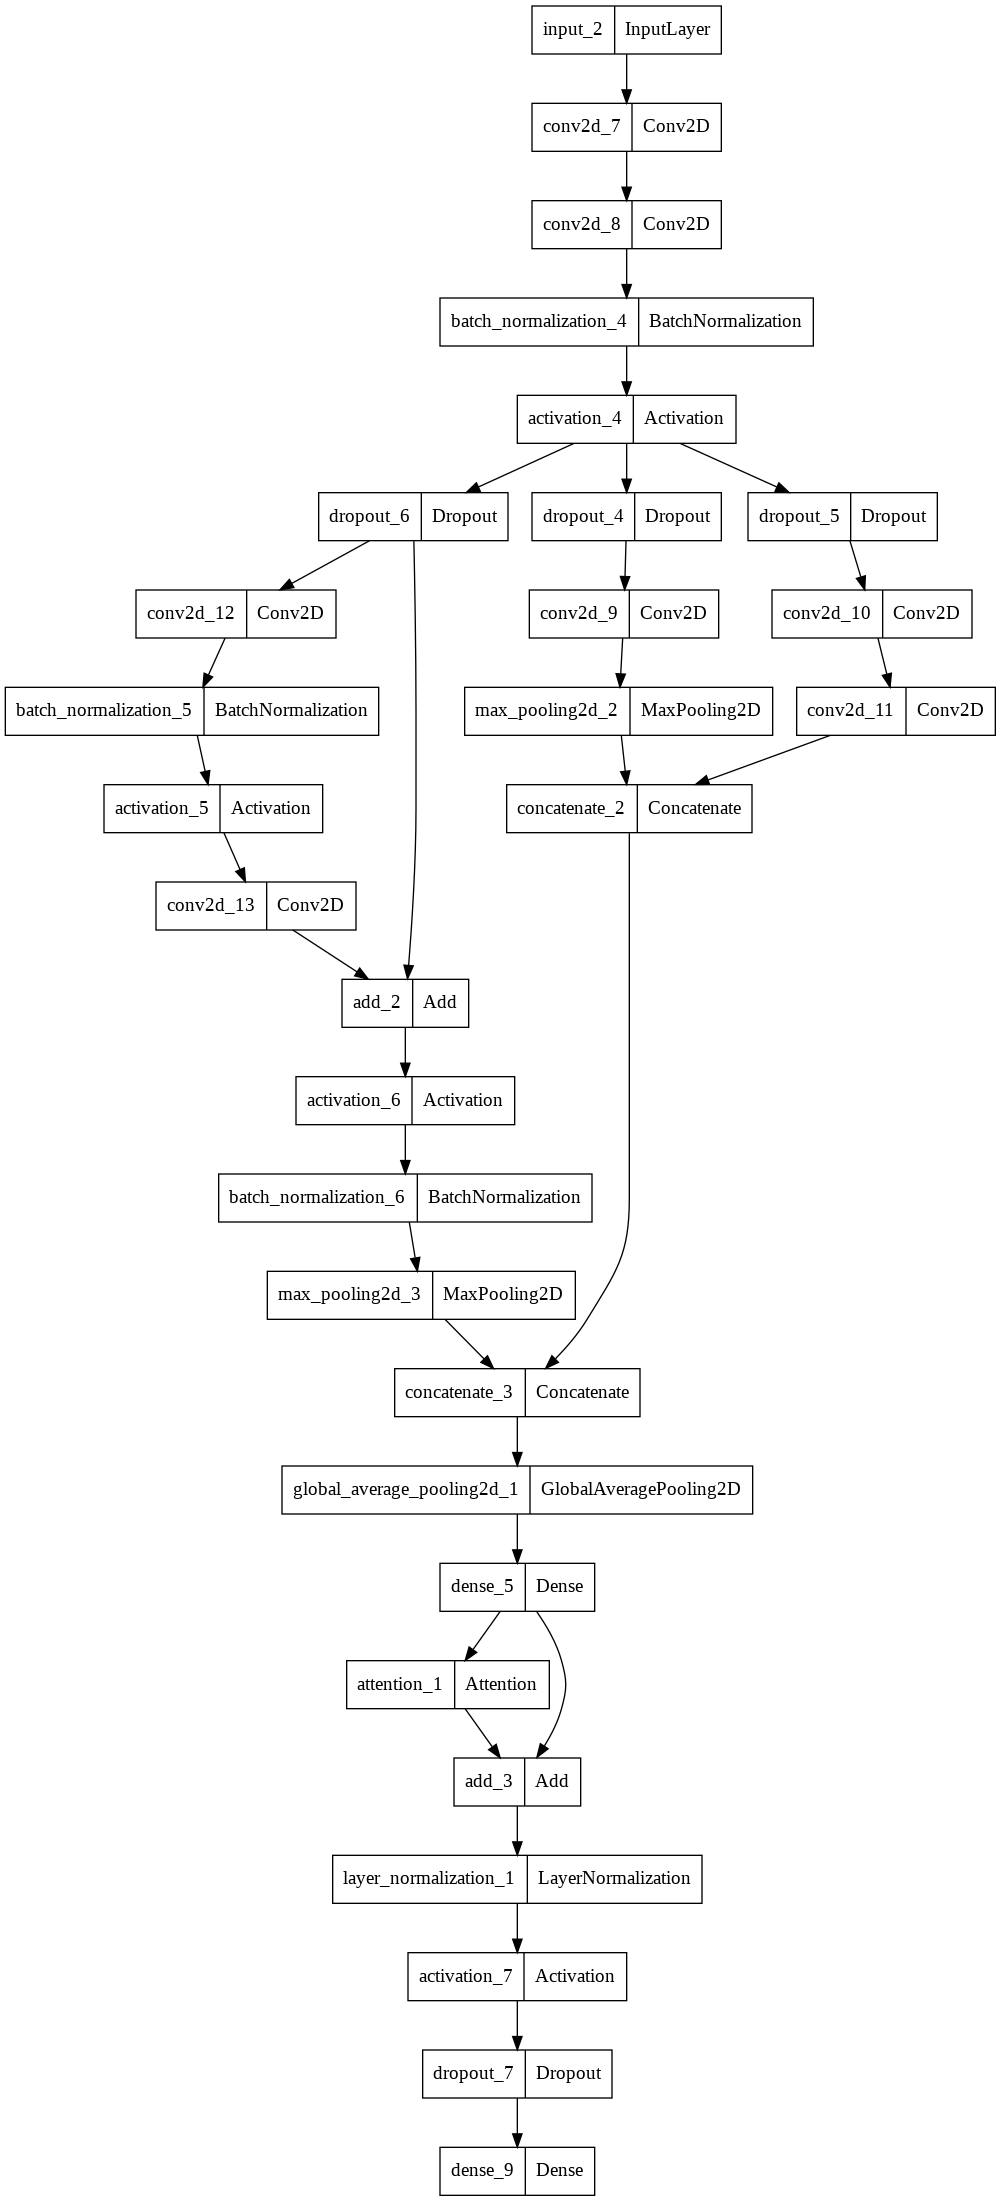

In [ ]:
inputs = tf.keras.layers.Input(shape=(32,32,3))

conv1 = tf.keras.layers.Conv2D(32, 1, padding="same", activation="relu")(inputs)
conv2 = tf.keras.layers.Conv2D(64, 3, padding="same", activation=None)(conv1)
conv_batch1 = tf.keras.layers.BatchNormalization()(conv2)
activation1 = tf.keras.layers.Activation("relu")(conv_batch1)

drop1 = tf.keras.layers.Dropout(0.5)(activation1)
branch1_conv1 = tf.keras.layers.Conv2D(64, 5, padding="same", activation="relu")(drop1)
branch1_pool = tf.keras.layers.MaxPool2D(2)(branch1_conv1)

drop2 = tf.keras.layers.Dropout(0.5)(activation1)
branch2_conv1 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(drop2)
branch2_conv2 = tf.keras.layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(branch2_conv1)

concat1 = tf.keras.layers.Concatenate(axis=-1)([branch1_pool, branch2_conv2])

drop3 = tf.keras.layers.Dropout(0.5)(activation1)
branch3_conv1 = tf.keras.layers.Conv2D(64, 3, padding="same", activation=None)(drop3)
branch3_norm1 = tf.keras.layers.BatchNormalization()(branch3_conv1)
branch3_relu1 = tf.keras.layers.Activation("relu")(branch3_norm1)
branch3_conv2 = tf.keras.layers.Conv2D(64, 3, padding="same", activation=None)(branch3_relu1)
branch3_add = tf.keras.layers.Add()([drop3, branch3_conv2])
branch3_relu2 = tf.keras.layers.Activation("relu")(branch3_add)
branch3_norm2 = tf.keras.layers.BatchNormalization()(branch3_relu2)
branch3_pool1 = tf.keras.layers.MaxPool2D()(branch3_norm2)

concat = tf.keras.layers.Concatenate(axis=-1)([concat1, branch3_pool1])
batch_norm = tf.keras.layers.BatchNormalization()(concat)
pooling = tf.keras.layers.GlobalAveragePooling2D()(concat)
dense1 = tf.keras.layers.Dense(128)(pooling)

attention = Attention(128)(dense1)
att_out = tf.keras.layers.Add()([dense1, attention])
att_out = tf.keras.layers.LayerNormalization()(att_out)
att_out = tf.keras.layers.Activation("relu")(att_out)
drop4 = tf.keras.layers.Dropout(0.5)(att_out)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(drop4)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="mix")
tf.keras.utils.plot_model(model)
#model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
            ]

In [ ]:
history = model.fit(train_ds, epochs=100, validation_data=valid_ds, callbacks=callbacks, verbose=1)

Epoch 1/100
1563/1563 [==============================] - 33s 20ms/step - loss: 1.7127 - accuracy: 0.3672 - val_loss: 1.3759 - val_accuracy: 0.4991 - lr: 0.0010
Epoch 2/100
1563/1563 [==============================] - 30s 19ms/step - loss: 1.3302 - accuracy: 0.5208 - val_loss: 1.5000 - val_accuracy: 0.4554 - lr: 0.0010
Epoch 3/100
1563/1563 [==============================] - 30s 19ms/step - loss: 1.1990 - accuracy: 0.5711 - val_loss: 1.1761 - val_accuracy: 0.5760 - lr: 0.0010
Epoch 4/100
1563/1563 [==============================] - 30s 19ms/step - loss: 1.1114 - accuracy: 0.6071 - val_loss: 1.3374 - val_accuracy: 0.5174 - lr: 0.0010
Epoch 5/100
1563/1563 [==============================] - 30s 19ms/step - loss: 1.0503 - accuracy: 0.6281 - val_loss: 1.1381 - val_accuracy: 0.5933 - lr: 0.0010
Epoch 6/100
1563/1563 [==============================] - 31s 20ms/step - loss: 0.9984 - accuracy: 0.6524 - val_loss: 0.9575 - val_accuracy: 0.6610 - lr: 0.0010
Epoch 7/100
1563/1563 [=================

**Две параллельные нитки с разным пулингом**

In [ ]:
inputs = tf.keras.layers.Input(shape=(32,32,3))
# first branch feature extractor
branch1_conv1 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="gelu")(inputs)
branch1_bn1 = tf.keras.layers.BatchNormalization()(branch1_conv1)
branch1_conv2 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="gelu")(branch1_bn1)
branch1_bn2 = tf.keras.layers.BatchNormalization()(branch1_conv2)
branch1_pool1 = tf.keras.layers.MaxPool2D(2, strides=1)(branch1_bn2)
drop1 = tf.keras.layers.Dropout(0.5)(branch1_pool1)

branch1_conv3 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="gelu")(drop1)
branch1_bn3 = tf.keras.layers.BatchNormalization()(branch1_conv3)
branch1_conv4 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="gelu")(branch1_bn3)
branch1_bn4 = tf.keras.layers.BatchNormalization()(branch1_conv4)
branch1_pool2 = tf.keras.layers.MaxPool2D(2, strides=1)(branch1_bn4)
drop2 = tf.keras.layers.Dropout(0.5)(branch1_pool2)

branch1_conv5 = tf.keras.layers.Conv2D(128, 3, padding="same", activation="gelu")(drop2)
branch1_bn5 = tf.keras.layers.BatchNormalization()(branch1_conv5)
branch1_conv6 = tf.keras.layers.Conv2D(128, 3, padding="same", activation="gelu")(branch1_bn5)
branch1_bn6 = tf.keras.layers.BatchNormalization()(branch1_conv6)
branch1_pool3 = tf.keras.layers.MaxPool2D(2, strides=1)(branch1_bn6)
drop3 = tf.keras.layers.Dropout(0.5)(branch1_pool3)
branch1_flat = tf.keras.layers.GlobalAveragePooling2D()(drop3)

# second branch feature extractor
branch2_conv1 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="gelu")(inputs)
branch2_bn1 = tf.keras.layers.BatchNormalization()(branch2_conv1)
branch2_conv2 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="gelu")(branch2_bn1)
branch2_bn2 = tf.keras.layers.BatchNormalization()(branch2_conv2)
branch2_pool1 = tf.keras.layers.AveragePooling2D(2, strides=1)(branch2_bn2)
drop4 = tf.keras.layers.Dropout(0.5)(branch2_pool1)

branch2_conv3 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="gelu")(drop4)
branch2_bn3 = tf.keras.layers.BatchNormalization()(branch2_conv3)
branch2_conv4 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="gelu")(branch2_bn3)
branch2_bn4 = tf.keras.layers.BatchNormalization()(branch2_conv4)
branch2_pool2 = tf.keras.layers.AveragePooling2D(2, strides=1)(branch2_bn4)
drop5 = tf.keras.layers.Dropout(0.5)(branch2_pool2)

branch2_conv5 = tf.keras.layers.Conv2D(128, 3, padding="same", activation="gelu")(drop5)
branch2_bn5 = tf.keras.layers.BatchNormalization()(branch2_conv5)
branch2_conv6 = tf.keras.layers.Conv2D(128, 3, padding="same", activation="gelu")(branch2_bn5)
branch2_bn6 = tf.keras.layers.BatchNormalization()(branch2_conv6)
branch2_pool3 = tf.keras.layers.AveragePooling2D(2, strides=1)(branch2_bn6)
drop6 = tf.keras.layers.Dropout(0.5)(branch2_pool3)
branch2_flat = tf.keras.layers.GlobalAveragePooling2D()(drop6)

# concat
branch_out = tf.keras.layers.Concatenate(axis=-1)([branch1_flat, branch2_flat])

# classifier
branch_out = tf.keras.layers.Dropout(0.5)(branch_out)
branch_out = tf.keras.layers.Dense(256, activation="gelu")(branch_out)
branch_out = tf.keras.layers.Dense(10, activation="softmax")(branch_out)

model = tf.keras.Model(inputs=inputs, outputs=branch_out, name="avg_max_cnn")

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
            ]

In [ ]:
history = model.fit(train_ds, epochs=100, validation_data=valid_ds, callbacks=callbacks, verbose=1)

Epoch 1/100
1563/1563 [==============================] - 106s 59ms/step - loss: 1.3185 - accuracy: 0.5202 - val_loss: 1.1745 - val_accuracy: 0.5924 - lr: 0.0010
Epoch 2/100
1563/1563 [==============================] - 93s 59ms/step - loss: 0.9591 - accuracy: 0.6565 - val_loss: 1.1258 - val_accuracy: 0.6212 - lr: 0.0010
Epoch 3/100
1563/1563 [==============================] - 93s 59ms/step - loss: 0.8200 - accuracy: 0.7101 - val_loss: 0.9216 - val_accuracy: 0.6842 - lr: 0.0010
Epoch 4/100
1563/1563 [==============================] - 95s 61ms/step - loss: 0.7276 - accuracy: 0.7444 - val_loss: 1.0527 - val_accuracy: 0.6421 - lr: 0.0010
Epoch 5/100
1563/1563 [==============================] - 93s 59ms/step - loss: 0.6545 - accuracy: 0.7703 - val_loss: 0.7363 - val_accuracy: 0.7534 - lr: 0.0010
Epoch 6/100
1563/1563 [==============================] - 92s 59ms/step - loss: 0.5969 - accuracy: 0.7901 - val_loss: 0.7247 - val_accuracy: 0.7633 - lr: 0.0010
Epoch 7/100
1563/1563 [================

In [ ]:
model.evaluate(valid_ds)

313/313 [==============================] - 5s 17ms/step - loss: 0.4239 - accuracy: 0.8608


[0.4239424765110016, 0.86080002784729]

**Custom ResNet18**

In [ ]:
class ResnetBlock(tf.keras.Model):
    def __init__(self, channels: int, down_sample=False):
        super(ResnetBlock, self).__init__()

        self.down_sample = down_sample
        strides = [2, 1] if down_sample else [1, 1]

        self.conv_1 = tf.keras.layers.Conv2D(channels, 
                                             strides=strides[0], 
                                             kernel_size=3, 
                                             padding="same", 
                                             kernel_initializer="he_normal")
        self.bn_1 = tf.keras.layers.BatchNormalization()
        self.conv_2 = tf.keras.layers.Conv2D(channels, 
                                             strides=strides[1],
                                             kernel_size=3, 
                                             padding="same", 
                                             kernel_initializer="he_normal")
        self.bn_2 = tf.keras.layers.BatchNormalization()
        self.add = tf.keras.layers.Add()

        if self.down_sample:
            self.res_conv = tf.keras.layers.Conv2D(channels, 
                                                   strides=2, 
                                                   kernel_size=1, 
                                                   kernel_initializer="he_normal", 
                                                   padding="same")
            self.res_bn = tf.keras.layers.BatchNormalization()
        
    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        x = self.add([x, res])
        out = tf.nn.relu(x)
        return out

class ResNet18(tf.keras.Model):

    def __init__(self, num_classes, channels=64, **kwargs):
        super(ResNet18, self).__init__(**kwargs)
        self.conv_1 = tf.keras.layers.Conv2D(channels, 
                                             kernel_size=7, 
                                             strides=2,
                                             padding="same", 
                                             kernel_initializer="he_normal")
        self.init_bn = tf.keras.layers.BatchNormalization()
        self.pool_2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.blocks = [ResnetBlock(64)]
        out_channels = channels
        for i in range(7):
            sample = False
            if i % 2 != 0:
                out_channels *= 2
                sample = True
            self.blocks.append(ResnetBlock(out_channels, down_sample=sample))
        self.avg_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.flat = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(num_classes, activation="softmax")
        self.build(input_shape=(None, 32, 32,3))

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in self.blocks:
            out = res_block(out)
        out = self.avg_pool(out)
        #out = self.flat(out)
        out = self.fc(out)
        return out

In [ ]:
net = ResNet18(10, channels=32)
net.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"]) 
callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
            ]

In [ ]:
history = net.fit(train_ds, epochs=5, validation_data=valid_ds, callbacks=callbacks, verbose=1)
# результаты пропали. Но этот подход много хуже baseline

**Tranfer learning (EffivientNetB0)**

EfficientNetB0 - наилучшим образом оптимизирована с точки зрения пропорций глубины, ширины и разрешения. Примечательно, что авторы нашли параметры
сети с использованием алгоритма поиска оптимальной архитектуры сети (то есть через optimized search). Кроме того, вместо ReLU используется swish
активация. Также есть фишки вроде: Inverted Residual Blocks (снижает число параметров сети), Squeeze and Excitation Block (учится взвешивать 
каналы на выходе conv слоя). EfficientNet состоит из 7 MBConv Block (получает на вход feature maps и параметры с которыми 
параметры блока: размеры ядра, фильтры, параметры вышеописанных блоков)

пробуем официальную модель в tf.keras и возьмем efficeint модуль (хоть и размер картинки маловат для такой сложной сети)

In [ ]:
!pip install -qq efficientnet

In [ ]:
from efficientnet.keras import EfficientNetB0  # выбрать что-то одно

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0

backbone = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(32,32,3), classes=num_classes)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# backbone = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32,32,3), classes=num_classes)  # OOM на 224

In [ ]:
# заморозим слои базовой сети. Можно этого не делать, тогда натренированные веса продолжат обновляться (это не всегда хорошо, надо чутко 
# подбирать гиперпараметры всей сети), будем считать, что базовая сеть уже хорошо умеет извлекать фичи, по которым можно отличить лягушку от машины

#for layer in backbone.layers:
#    layer.trainable = False

backbone.trainable = False

# пробуем дообучать веса
# for layer in backbone.layers:
#     if isinstance(layer, tf.keras.layers.BatchNormalization):  # чтобы не уничтожить хорошие веса
#         layer.trainable = False
#     else:
#         layer.trainable = True

In [ ]:
class Swish(tf.keras.layers.Layer):
    def __init__(self, beta):
        super(Swish, self).__init__()
        self.beta = tf.Variable(initial_value=beta, trainable=True)
        self._name = "Swish"

    def call(self, x):
        return x * tf.nn.sigmoid(self.beta * x)

In [ ]:
beta = 1.  # beta = 1, function = SiLU, beta = 0, function = linear x/2

model = tf.keras.Sequential()

model.add(backbone)
model.add(tf.keras.layers.GlobalAveragePooling2D())

# дополниельный эксперимент с активацией swish
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256, activation=None))
# model.add(tf.keras.layers.Lambda(lambda x: x * tf.nn.sigmoid(beta * x), name="swish"))  # если beta non-trainable константа
model.add(Swish(beta))

model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1, 1, 1280)       4049571   
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 Swish (Swish)               (None, 256)               1         
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                      

In [ ]:
def aug_fn(image):  # для keras.applications не требуется scaling и resize
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img, tf.float32)
    return aug_img

In [ ]:
# augmentations

(x_train, y_train), (x_test, y_test) = load_data()
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

AUTOTUNE = tf.data.AUTOTUNE
# aug without gray
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(partial(process_image), num_parallel_calls=AUTOTUNE).cache().shuffle(len(x_train)).batch(8).prefetch(AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(lambda x,y: (tf.cast(x, tf.float32),y)).cache().batch(8).prefetch(AUTOTUNE)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
            ]

In [ ]:
history = model.fit(train_ds, epochs=100, validation_data=valid_ds, callbacks=callbacks, verbose=1)
# сложная модель для таких данных... обучение идет медленно (с маленькими изменениями) к 10 эпохе чуть более 0.54 accuracy

Epoch 1/100
6250/6250 [==============================] - 329s 40ms/step - loss: 1.8004 - accuracy: 0.3562 - val_loss: 1.4806 - val_accuracy: 0.4916 - lr: 1.0000e-04
Epoch 2/100
6250/6250 [==============================] - 195s 31ms/step - loss: 1.6228 - accuracy: 0.4234 - val_loss: 1.3934 - val_accuracy: 0.5193 - lr: 1.0000e-04
Epoch 3/100
6250/6250 [==============================] - 197s 31ms/step - loss: 1.5892 - accuracy: 0.4336 - val_loss: 1.3577 - val_accuracy: 0.5273 - lr: 1.0000e-04
Epoch 4/100
6250/6250 [==============================] - 206s 33ms/step - loss: 1.5704 - accuracy: 0.4402 - val_loss: 1.3494 - val_accuracy: 0.5322 - lr: 1.0000e-04
Epoch 5/100
6250/6250 [==============================] - 187s 30ms/step - loss: 1.5566 - accuracy: 0.4480 - val_loss: 1.3421 - val_accuracy: 0.5320 - lr: 1.0000e-04
Epoch 6/100
6250/6250 [==============================] - 188s 30ms/step - loss: 1.5485 - accuracy: 0.4463 - val_loss: 1.3332 - val_accuracy: 0.5403 - lr: 1.0000e-04
Epoch 7/10

**Zero-shot learning**

По традиции немного экзотики. CLIP модель к теме сверточных сетей не имеет отношения. При разработке модели авторы использовали вариант сверточной сети для feature extractor ResNet50, но остановились на модели ViT (с патчами изображения в качестве токенов и полносвязными слоями трасформера). Для текста использовали языковую модель (GPT-2 вроде).

In [ ]:
# CLIP hugging face
from transformers import CLIPProcessor, TFCLIPModel

In [ ]:
model = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Downloading:   0%|          | 0.00/606M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


In [ ]:
classes = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
(x_train, y_train), (x_test, y_test) = load_data()

In [ ]:
image = x_train[0]

text_inputs = processor([f"a photo of a {cls}" for cls in classes], padding=True, return_tensors="tf")
image_inputs = processor(images=image, return_tensors="tf")

In [ ]:
text_features = model.get_text_features(**text_inputs)
image_features = model.get_image_features(**image_inputs)

In [ ]:
image_features /= tf.norm(image_features, axis=-1, keepdims=True)
text_features /= tf.norm(text_features, axis=-1, keepdims=True)

In [ ]:
similarity = 100 * tf.matmul(image_features, text_features, transpose_b=True)
similarity = tf.nn.softmax(similarity, axis=-1).numpy()

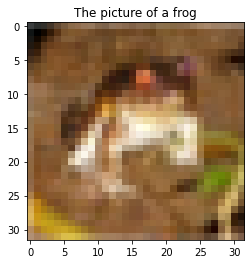

In [ ]:
plt.imshow(x_train[0])
plt.title(f"The picture of a {classes[similarity.argmax(1).item()]}")
plt.show()

**Еще выводы**

К ранее сказанному нужно добавить, что играя с глубиной сети, количеством ветвей, фильтров и т.д. необходимо не забывать, что в первую очередь надо решить какая будет архитектура сети - это ключевой момент! А дальше уже идти от несложной сети к более сложной.